# Youtube faces with facial keypoints

Prerequisite: downloaded dataset to be found under `./data`

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

import re
import multiprocessing as mp
from functools import partial
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Explore: show content of arbitrary npz

In [3]:
npz_path = "data/youtube_faces_with_keypoints_large_7/Kristy_Curry_0.npz"

Use option `mmap_mode='r'` to avoid loading all data in memory and work directly with it from disk.

In [4]:
data = np.load(npz_path, mmap_mode='r')

In [5]:
data['colorImages'].shape

(216, 201, 3, 107)

`216 x 201` are the dimensions (`height x width`) of the given frame in the video, `3` is for `RGB` color channels and `107` is the number of frames.

In [6]:
data['boundingBox'].shape

(4, 2, 107)

As specified, we have `4` coordinates that form a bounding box around a face for each of the 107 frames in the video. Although we would be fine with only the upper left and lower right, if it is by definition a rectangle.

In [7]:
data['landmarks2D'].shape

(68, 2, 107)

And lastly, the `68` coordinates for face landmarks. Let's visualize:

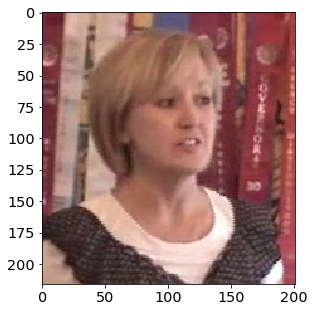

In [8]:
first_frame = data['colorImages'][:, :, :, 0]
fig, ax = plt.subplots()
ax.imshow(first_frame)

Now with landmarks...

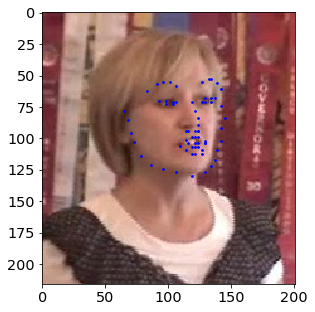

In [9]:
ax.scatter(x=data['landmarks2D'][:, 0, 0], y=data['landmarks2D'][:, 1, 0], s=3, c='b')
fig

...and the bounding box (inspired from: https://stackoverflow.com/a/43971350):

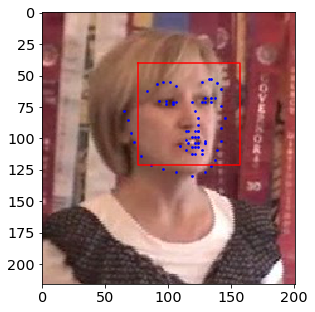

In [10]:
coord = list(data['boundingBox'][:, :, 0])
coord.append(coord[0])
coord[2], coord[3] = coord[3], coord[2]

xs, ys = zip(*coord)
ax.plot(xs, ys, c='r')
fig

## Task 1 - generate raw dataset

In [11]:
def process_npz(npz_file):
    """
    Reads video data from provided npz file and saves it in raw,
    uncompressed format (frame by frame) to disk.
    Output folder structure:
        Raw |-- images
            |     |-- image1.png
            |     |-- image2.png
            |     |-- etc.
            |-- bounding_boxes
            |     |-- image1.npy
            |     |-- image2.npy
            |     |-- etc.
            |-- landmarks2D
                  |-- image1.npy
                  |-- image2.npy
                  |-- etc.
                  
    Expects output path structure to be already existing.
    
    Args:
        npz_file: Path to npz file
    
    Returns:
        Void
        Side effect: npz content is saved to disk at prespecified
        path as png and npy dump
    """
    
    data = np.load(npz_file, mmap_mode='r')
    num_frames = data['boundingBox'].shape[2]
    
    for idx in range(num_frames):
        frame = data['colorImages'][:, :, :, idx]
        bbox = data['boundingBox'][:, :, idx]
        landmarks = data['landmarks2D'][:, :, idx]
        
        filename = '{}_frame{}'.format(npz_file.stem, str(idx + 1))
        
        image_path = './Raw/images/{}.png'.format(filename)
        bbox_path = './Raw/bounding_boxes/{}'.format(filename)
        landmarks_path = './Raw/landmarks2D/{}'.format(filename)
        
        plt.imsave(image_path, frame)
        np.save(bbox_path, bbox)
        np.save(landmarks_path, landmarks)

In [12]:
def parallel_run(func, iterable, batch_size):
    """
    Applies method `func` on provided iterable.
    
    Args:
        func: method to apply on iterable
        iterable: elements to be processed
        batch_size: size of batch to be processed by a single job
    Returns:
        Void
    """
    
    pool = mp.Pool(processes=None)
    pool.map(func, iterable, batch_size)
    pool.close()
    pool.join()

In [13]:
Path.mkdir(Path('./Raw'))
Path.mkdir(Path('./Raw/images'))
Path.mkdir(Path('./Raw/bounding_boxes'))
Path.mkdir(Path('./Raw/landmarks2D'))

npz_files = []
for data_dir in Path('./data/').glob('*_large_*'):
    npz_files.extend([npz_file for npz_file in data_dir.glob('*')])
    
parallel_run(process_npz, npz_files, 128)

## Task 2 - resizing

### Optional: most often occurring shape and average width/height

Let's obtain the dataframe containing video metadata.
Note: the large CSV contains data for all the folders, including the small one, therefore we will have to drop those records.

In [14]:
large_df = pd.read_csv("./data/youtube_faces_with_keypoints_large.csv")
small_df = pd.read_csv("./data/youtube_faces_with_keypoints_small.csv")
df = large_df[~large_df.videoID.isin(small_df.videoID)]

First a quick check for the previous task, whether we have processed all the data:

In [15]:
df['videoDuration'].sum()

137382.0

In [16]:
!ls ./Raw/images | wc -l

137382


In [17]:
!ls ./Raw/bounding_boxes | wc -l

137382


In [18]:
!ls ./Raw/landmarks2D | wc -l

137382


All looks fine! Let's calculate **average height and width** weighted by video duration:

In [19]:
(df['imageHeight'] * df['videoDuration']).sum() / df['videoDuration'].sum()

209.83794092384738

In [20]:
(df['imageWidth'] * df['videoDuration']).sum() / df['videoDuration'].sum()

195.7530972034182

**Most often occurring shape:**

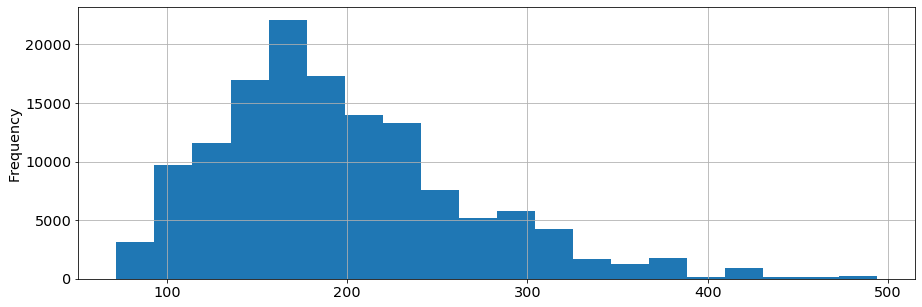

In [21]:
df['imageWidth'].plot(kind="hist", 
                      weights=df['videoDuration'], 
                      bins=20, 
                      grid=True)

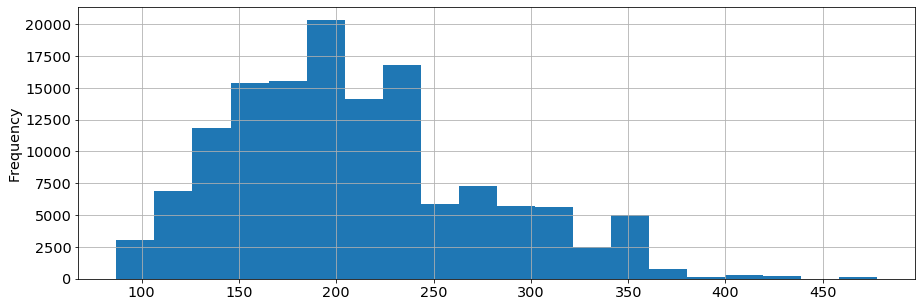

In [22]:
df['imageHeight'].plot(kind="hist", 
                       weights=df['videoDuration'], 
                       bins=20, 
                       grid=True)

The most often occurring shape is roughly around [160-180] in width and [185-205] in height.

### Resizing

In [23]:
def resize_raw(subj, new_size):
    """
    Resizes all frames of a given video to the specified dimension,
    while also scaling landmarks and the bounding box accordingly.
    
    Output folder structure:
        Processed |-- images
                  |     |-- subj_frame1.png
                  |     |-- subj_frame2.png
                  |     |-- etc.
                  |-- bounding_boxes
                  |     |-- subj_frame1.npy
                  |     |-- subj_frame2.npy
                  |     |-- etc.
                  |-- landmarks2D
                        |-- subj_frame1.npy
                        |-- subj_frame2.npy
                        |-- etc.
                  
    Expects output path structure to be already existing.
    
    Args:
        subj: string identifier of given video e.g. 'Kristy_Curry_0'
        new_size: tuple of format (new_height, new_width)
    
    Returns:
        Void
        Side effect: resized images and data saved to 
        prespecified path
    """
    
    # Calculate dimension ratio to current size
    # This will be constant among frames of the same video    
    old_width, old_height = \
        Image.open('./Raw/images/{}_frame1.png'.format(subj)).size
    
    ratio = np.array([new_size[1] / old_width, 
                      new_size[0] / old_height])
    
    for img in Path('./Raw/images/').glob('{}_frame*'.format(subj)):
        name = img.stem
        
        frame = Image.open('./Raw/images/{}.png'.format(name))
        bbox = np.load('./Raw/bounding_boxes/{}.npy'.format(name))
        landmarks = np.load('./Raw/landmarks2D/{}.npy'.format(name))

        # Resize image - arg tuple is (width, height)
        frame = frame.resize((new_size[1], new_size[0]))
        
        # Recalculate coordinates
        new_bbox = np.round(np.multiply(bbox, ratio))
        new_landmarks = np.round(np.multiply(landmarks, ratio))
        
        image_path = './Processed/images/{}.png'.format(name)
        bbox_path = './Processed/bounding_boxes/{}'.format(name)
        landmarks_path = './Processed/landmarks2D/{}'.format(name)
        
        frame.save(image_path, "PNG")
        np.save(bbox_path, new_bbox)
        np.save(landmarks_path, new_landmarks)

### Optional: concatenate in single file

Will help with validation, so let's implement it here.

In [24]:
red = [1, 0, 0, 1]
blue = [0, 0, 1, 1]

def save_video_with_bbox_and_landmarks(subj):
    """
    Draws the bounding box and landmarks on all resized
    frames of specified video.
    
    Output folder structure:
        Processed |-- images
                  |-- bounding_boxes
                  |-- landmarks2D
                  |-- concat
                        |-- subj_frame1.png
                        |-- subj_frame2.png
                  
    Expects output path structure to be already existing.
    
    Args:
        subj: string identifier of given video e.g. 'Kristy_Curry_0'
    
    Returns:
        Void
        Side effect: concatenated frame saved to disk as png
    """
    
    for img in Path('./Processed/images/').glob('{}_frame*'.format(subj)):
        name = img.stem
        
        frame = plt.imread('./Processed/images/{}.png'.format(name))
        bbox = np.load('./Processed/bounding_boxes/{}.npy'.format(name))
        landmarks = np.load('./Processed/landmarks2D/{}.npy'.format(name))

        coord = list(bbox[:, :])
        coord[2], coord[3] = coord[3], coord[2]
        xs, ys = zip(*coord)
        
        # Draw landmarks
        for landmark in range(landmarks.shape[0]):
            x = int(landmarks[landmark, 0])
            y = int(landmarks[landmark, 1])

            frame[y - 1:y + 1, x - 1:x + 1, :] = blue

        # Draw bounding box (counter-clockwise)
        frame[int(ys[0]):int(ys[1]) + 1, 
              int(xs[0]):int(xs[1]) + 1, 
              :] = red
        
        frame[int(ys[1]):int(ys[2]) + 1, 
              int(xs[1]):int(xs[2]) + 1, 
              :] = red
        
        frame[int(ys[3]):int(ys[2]) + 1, 
              int(xs[3]):int(xs[2]) + 1, 
              :] = red

        frame[int(ys[0]):int(ys[3]) + 1, 
              int(xs[0]):int(xs[3]) + 1, 
              :] = red

        plt.imsave('./Processed/concat/{}.png'.format(name), frame)

In [25]:
# Create directory structure for output
Path.mkdir(Path('./Processed'))
Path.mkdir(Path('./Processed/images'))
Path.mkdir(Path('./Processed/bounding_boxes'))
Path.mkdir(Path('./Processed/landmarks2D'))
Path.mkdir(Path('./Processed/concat'))

In [26]:
subjects = df['videoID'].values
new_size = (195, 170)
    
parallel_run(partial(resize_raw, new_size=new_size), subjects, 128)

Generate concatenated images:

In [27]:
parallel_run(save_video_with_bbox_and_landmarks, subjects, 128)

Let's load a concatenated image for validation:

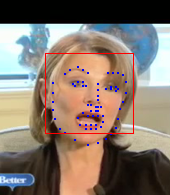

In [28]:
img = Image.open('./Processed/concat/{}_frame225.png'.format('Linda_Franklin_4'))
img

Width and height, in order:

In [29]:
img.size

(170, 195)

## Task 3 - train-validation-test split

### Terminology

- training set: used to optimize model parameters on, fitting
- validation/dev set: used for model selection and hyperparameter tuning
- test set: provides an unbiased evaluation of selected model [1]

### Considerations

#### Classification problem

For sake of simplicity, let the task be the identification of the celebrity present in a sample.

#### Shuffling

In case we considered a single frame to be the unit of processing, the first observation we should make is that frames of the same video will violate the *identically and independently distributed (i.i.d.)* assumption. [2][3] This in turn means that if we shuffled this data before splitting, we might end up with frames in the validation and training sets that are "artificially similar (close in time)" [4] and lead to higher validation scores. In other words, you essentially evaluate on samples of the validation set that differ very little from training set samples, since they could even be consecutive frames in time. This is something we can easily avoid by considering **a single video to be a sample** and not mix covideo frames between splits.

Since the current dataset of 1154 samples with 347 labels (roughly 4 samples per label) can not be effectively splitted into 3 in a stratified manner, we will double the number of samples while also trying to avoid violating the *i.i.d.* assumption. Video lengths vary between [42-240] frames, there are minimum 3 videos per label, so let's consider splitting the videos into **non-overlapping 20-frame segments** and keep 6 such groups in total for each label.

*Note: ideally I would consider reducing class imbalance by augmentation instead of undersampling.*

#### Validation and test set

Consider the scenario in which the validation and test sets come from different distributions. In this case we would look for a model that performs well on the validation set, but since the test set is from a different distribution, the selected model will perform poorly on it, since it was tuned to generalize on a different distribution. Therefore it is imperative that these two sets come from the same distribution. [5] For this reason, we will apply a stratified split on the data based on label (i.e. person present in video).

Another consideration is that validation and test sets should resemble as much as possible data that we expect in production. [6] Again for sake of simplicity, let's assume that the model will encounter in the wild every label with equal probability.

#### Size, ratio

The "classic" rule of 60% train, 20% validation and 20% test data applies fine for datasets of sizes of 10K, 100K samples. In case you are provided with a dataset with even millions of samples, one could even split having 98% train, 1% validation and 1% test. [5] The rationale behind this is that the latter two sets "should be just big enough to represent accurately the performance of the model" [6], which in the million range already amount up to 10K samples with 1% each.

Karpathy et al. attempted classification on a dataset of ~1 million videos belonging to 487 classes and they opted for a split of 70-10-20. They also considered the other interesting aspect of *duplicate videos* on YouTube, which could again violate the *i.i.d.* assumption, but this time around on video level. However, they estimated that this could only have an insignificant effect on model performance due to how they generate extra samples of 30 second clips from their videos of an average length of 5:36 minutes. [7]

Since the number of samples we will be working with will be in the range of thousands, a 60-20-20 split is more fitting. Given also the distribution of samples that we have, reality will be closer to 66-16-16.

### Split

In [30]:
RANDOM_STATE = 12358
GROUP_SIZE = 20

In [31]:
def frame_id(frame):
    return int(re.match('.*?([0-9]+).png$', str(frame)).group(1))

In [32]:
# https://stackoverflow.com/a/434328
def chunker(seq, size):
    for pos in range(0, len(seq), size): yield seq[pos:pos + size]

In [33]:
videos = list(map(lambda fname: fname.stem[:-7], Path('./Processed/images/').glob('*_frame1.png')))

In [34]:
X = []
for video in videos:
    curr_frames = Path('./Processed/images/').glob(video + '_*')
    sorted_frames = sorted(curr_frames, key=lambda frame: frame_id(frame))
    for group in chunker(sorted_frames, GROUP_SIZE):
        X.append(group)
    # Drop the last one if it's shorter
    if len(X[-1]) < GROUP_SIZE:
        del X[-1]

In [35]:
y = list(map(lambda video: 
             ''.join(str(video[0]).split('_')[:2]).split('/')[2], 
             X))

In [36]:
# Keep 6 samples by choice for each label - undersampling
df = pd.DataFrame(data={'data': X, 'label': y})
for label in np.unique(y):
    curr_label = df[df['label'] == label]
    drop = curr_label.sample(n=len(curr_label) - 6, 
                             random_state=RANDOM_STATE).index
    df.drop(drop, inplace=True)

In [37]:
X_train, X_test, y_train, y_test = \
    train_test_split(df.data.values, df.label.values,
                     stratify=df.label.values,
                     test_size=0.1666,
                     shuffle=True,
                     random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train,
                     stratify=y_train,
                     test_size=0.2,
                     shuffle=True,
                     random_state=RANDOM_STATE)

In [38]:
len(X_train), len(X_val), len(X_test)

(1388, 347, 347)

### Sources

1. https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
2. https://www.quora.com/How-do-we-treat-time-series-data-differently-than-other-data-before-passing-it-to-a-Bayes-predictor-or-any-other-machine-learning-algorithms
3. https://www.fast.ai/2017/11/13/validation-sets/
4. https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling
5. https://www.coursera.org/lecture/deep-neural-network/train-dev-test-sets-cxG1s (Andrew Ng)
6. http://cs230.stanford.edu/blog/split/
7. A. Karpathy, G. Toderici, S. Shetty, T. Leung, R. Sukthankar and L. Fei-Fei, "Large-Scale Video Classification with Convolutional Neural Networks," 2014 IEEE Conference on Computer Vision and Pattern Recognition, Columbus, OH, 2014, pp. 1725-1732. https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42455.pdf